In [9]:
import psycopg2
import pandas as pd

In [499]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

In [12]:
host="192.168.2.23"
port=5432
user="amt"
dbname="qdap_test"

In [46]:
def make_connection_to_db(host, port, user, dbname):
    conn = psycopg2.connect(host= host, port=port, user=user, dbname=dbname)
    cursor = conn.cursor()
    return cursor, conn

In [48]:
def fetch_options_data(cursor, symbol, strike_price, date, month, year, type):
    cursor.execute(
        f'''
            SELECT *
            FROM ohlcv_options_per_minute oopm
            WHERE symbol = '{option}' 
            AND strike = {strike_price} 
            AND extract(year from oopm.expiry) = {year} 
            AND extract(month from oopm.expiry) = {month}
            AND extract(day from oopm.expiry) = {date}
            AND opt_type = '{type}';
        '''
    )
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

def fetch_options_data(cursor, symbol, expiry):
    cursor.execute(
        f'''
            SELECT *
            FROM ohlcv_options_per_minute oopm
            WHERE symbol = '{symbol}' 
            AND expiry_type = 'I'
            AND expiry = (
                SELECT MAX(oopmm.expiry)
                FROM ohlcv_options_per_minute oopmm
                WHERE oopmm.symbol = '{symbol}'
                AND oopmm.expiry_type = 'I'
                AND oopmm.expiry <= '{expiry}'
            )
            ORDER BY date_timestamp ASC;
            
        '''
    )
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [50]:
def fetch_futures_data(cursor, symbol, x=0):
    query = f'''
        SELECT *
        FROM ohlcv_future_per_minute ofpm
        WHERE ofpm.symbol = '{symbol}'
        AND ofpm.expiry_type = 'I'
        AND ofpm.expiry = (
            SELECT ofpmm.expiry 
            FROM ohlcv_future_per_minute ofpmm
            WHERE ofpmm.symbol = '{symbol}'
            AND ofpmm.expiry_type = 'I'
            GROUP BY ofpmm.expiry
            OFFSET {x}
            LIMIT 1
        )
        ORDER BY date_timestamp ASC;
    '''
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [52]:
def fetch_equity_data(cursor, symbol, begin, expiry):
    query = f'''
        SELECT *
        FROM ohlcv_cm_per_minute ocpm
        WHERE ocpm.symbol = '{symbol}'
        AND date_timestamp <= '{expiry}'
        AND date_timestamp >= '{begin}'
        ORDER BY date_timestamp ASC;
    '''
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [54]:
def fetch(host, port, user, dbname, symbol, x=15):
    cursor, conn = make_connection_to_db(host, port, user, dbname)
    # hardcoded for near month expiry
    df_futures = fetch_futures_data(cursor, symbol, x) # date is the expiry
    expiry = df_futures['expiry'].iloc[0]
    df_options = fetch_options_data(cursor, symbol, expiry)
    cursor.close()
    conn.close()
    return df_futures, df_options

In [56]:
symbol = "BANKNIFTY"
x = 20 # index of the array of all the unique expiries of I futures. 

In [58]:
DF_FUTURES, DF_OPTIONS = fetch(host, port, user, dbname, symbol, x)

In [60]:
df_futures = DF_FUTURES.copy()
df_options = DF_OPTIONS.copy()

In [62]:
df_futures = df_futures.drop_duplicates(subset='date_timestamp', keep='first')
df_futures.set_index('date_timestamp', inplace=True)
df_options.set_index('date_timestamp', inplace=True)
df_futures

,symbol,open,low,high,close,volume,expiry,expiry_type,id
date_timestamp,,,,,,,,,
2023-12-01 09:15:00,BANKNIFTY,4479145,4476270,4483685,4482335,48975,2023-12-28 14:30:00,I,60243857
2023-12-01 09:16:00,BANKNIFTY,4482165,4478740,4482625,4482285,29175,2023-12-28 14:30:00,I,13448955
2023-12-01 09:17:00,BANKNIFTY,4482795,4481350,4483715,4483200,27660,2023-12-28 14:30:00,I,13448956
2023-12-01 09:18:00,BANKNIFTY,4483240,4483240,4486500,4486500,23925,2023-12-28 14:30:00,I,60243860
2023-12-01 09:19:00,BANKNIFTY,4486430,4485600,4487500,4486620,15240,2023-12-28 14:30:00,I,13448958
...,...,...,...,...,...,...,...,...,...
2023-12-28 15:25:00,BANKNIFTY,4850775,4850370,4851095,4850655,8535,2023-12-28 14:30:00,I,15301364
2023-12-28 15:26:00,BANKNIFTY,4850655,4850530,4851405,4851100,5400,2023-12-28 14:30:00,I,62096268
2023-12-28 15:27:00,BANKNIFTY,4851100,4850700,4851300,4851015,2130,2023-12-28 14:30:00,I,15301366


In [64]:
# NOTE THAT OPTIONS AND FUTURES EXPIRY IN THE QDAP DATABASE ARE NOT FOLLOWING THE SAME FORMAT.
expiry_options = pd.Timestamp(df_options['expiry'].iloc[0]).date()
expiry_futures = pd.Timestamp(df_futures['expiry'].iloc[0]).date()
starts_options = pd.Timestamp(df_options.index[0]).date()
starts_futures = pd.Timestamp(df_futures.index[0]).date()

start_intersection = max(starts_options, starts_futures)
end_intersection = min(expiry_options, expiry_futures)
start_intersection = pd.Timestamp.combine(start_intersection, pd.Timestamp('09:15:00').time())
end_intersection = pd.Timestamp.combine(end_intersection, pd.Timestamp('15:29:00').time())

print("starts_options:", starts_options)
print("expiry_options:", expiry_options)
print("starts_futures:", starts_futures)
print("expiry_futures:", expiry_futures)
print("start_intersection:", start_intersection)
print("end_intersection:", end_intersection)

range_futures = (df_futures.index <= end_intersection) & (df_futures.index >= start_intersection)
range_options = (df_options.index <= end_intersection) & (df_options.index >= start_intersection)

df_futures = df_futures[range_futures]
df_options = df_options[range_options]
# df_futures = df_futures[range_futures]
# df_options = df_options[range_options]

starts_options: 2023-12-01
expiry_options: 2023-12-28
starts_futures: 2023-12-01
expiry_futures: 2023-12-28
start_intersection: 2023-12-01 09:15:00
end_intersection: 2023-12-28 15:29:00


In [66]:
df_futures

,symbol,open,low,high,close,volume,expiry,expiry_type,id
date_timestamp,,,,,,,,,
2023-12-01 09:15:00,BANKNIFTY,4479145,4476270,4483685,4482335,48975,2023-12-28 14:30:00,I,60243857
2023-12-01 09:16:00,BANKNIFTY,4482165,4478740,4482625,4482285,29175,2023-12-28 14:30:00,I,13448955
2023-12-01 09:17:00,BANKNIFTY,4482795,4481350,4483715,4483200,27660,2023-12-28 14:30:00,I,13448956
2023-12-01 09:18:00,BANKNIFTY,4483240,4483240,4486500,4486500,23925,2023-12-28 14:30:00,I,60243860
2023-12-01 09:19:00,BANKNIFTY,4486430,4485600,4487500,4486620,15240,2023-12-28 14:30:00,I,13448958
...,...,...,...,...,...,...,...,...,...
2023-12-28 15:25:00,BANKNIFTY,4850775,4850370,4851095,4850655,8535,2023-12-28 14:30:00,I,15301364
2023-12-28 15:26:00,BANKNIFTY,4850655,4850530,4851405,4851100,5400,2023-12-28 14:30:00,I,62096268
2023-12-28 15:27:00,BANKNIFTY,4851100,4850700,4851300,4851015,2130,2023-12-28 14:30:00,I,15301366


In [68]:
df_options

,symbol,open,high,low,close,volume,opt_type,strike,expiry_type,id,expiry
date_timestamp,,,,,,,,,,,
2023-12-01 09:15:00,BANKNIFTY,150015,152500,146510,151500,735,CE,4350000,I,136791464,2023-12-28
2023-12-01 09:15:00,BANKNIFTY,6060,6500,5610,5770,1980,PE,4200000,I,136791109,2023-12-28
2023-12-01 09:15:00,BANKNIFTY,19500,20955,19010,19010,7635,PE,4350000,I,136791731,2023-12-28
2023-12-01 09:15:00,BANKNIFTY,3095,3250,3000,3000,240,PE,4100000,I,136822485,2023-12-28
2023-12-01 09:15:00,BANKNIFTY,1075,1495,1070,1105,810,CE,5000000,I,136845333,2023-12-28
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 15:29:00,BANKNIFTY,5,5,5,5,1005,CE,5100000,I,158618787,2023-12-28
2023-12-28 15:29:00,BANKNIFTY,5,5,5,5,4545,PE,4050000,I,158613143,2023-12-28
2023-12-28 15:29:00,BANKNIFTY,5,5,5,5,795,PE,3900000,I,158612789,2023-12-28


In [70]:
df_calls = df_options[(df_options['opt_type'] == 'CE')]
df_puts  = df_options[(df_options['opt_type'] == 'PE')]

In [72]:
df_calls_ram = df_calls.pivot(columns='strike', values='close').ffill()
df_puts_ram = df_puts.pivot(columns='strike', values='close').ffill()
df = [df_puts_ram, df_calls_ram]

In [73]:
print(df_calls_ram.shape)
print(df_futures.shape)

(7125, 119)
(7125, 9)


In [76]:
df_calls_ram

strike,3600000,3700000,3750000,3800000,3850000,3900000,3950000,3980000,3990000,4000000,...,5070000,5080000,5100000,5150000,5200000,5250000,5300000,5350000,5400000,5450000
date_timestamp,,,,,,,,,,,,,,,,,,,,,
2023-12-01 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,930.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 15:25:00,1251825.0,1184195.0,1114320.0,1056185.0,1006000.0,952400.0,900000.0,848955.0,785820.0,852000.0,...,5.0,5.0,5.0,5.0,5.0,5.0,10.0,5.0,5.0,5.0
2023-12-28 15:26:00,1251825.0,1184195.0,1114320.0,1056185.0,1006000.0,952400.0,900000.0,848955.0,785820.0,852000.0,...,5.0,5.0,5.0,5.0,10.0,5.0,10.0,15.0,5.0,5.0
2023-12-28 15:27:00,1251825.0,1184195.0,1114320.0,1056185.0,1006000.0,953000.0,900000.0,848955.0,785820.0,853500.0,...,5.0,5.0,5.0,5.0,5.0,10.0,10.0,10.0,5.0,5.0


In [78]:
df_puts_ram

strike,3300000,3600000,3650000,3700000,3750000,3800000,3850000,3900000,3950000,3980000,...,5060000,5070000,5080000,5100000,5150000,5200000,5250000,5300000,5350000,5400000
date_timestamp,,,,,,,,,,,,,,,,,,,,,
2023-12-01 09:15:00,NaN,NaN,NaN,360.0,NaN,950.0,NaN,NaN,1820.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:16:00,NaN,NaN,NaN,590.0,605.0,945.0,NaN,NaN,1840.0,NaN,...,NaN,NaN,NaN,613000.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:17:00,NaN,NaN,NaN,590.0,605.0,945.0,NaN,NaN,1790.0,1925.0,...,NaN,NaN,NaN,610000.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:18:00,NaN,NaN,NaN,590.0,605.0,945.0,NaN,NaN,1775.0,1930.0,...,NaN,NaN,NaN,610000.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:19:00,305.0,NaN,NaN,590.0,605.0,970.0,NaN,NaN,1760.0,1920.0,...,NaN,NaN,NaN,610000.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 15:25:00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,208885.0,218500.0,227875.0,250000.0,298900.0,350235.0,408430.0,447945.0,493515.0,540000.0
2023-12-28 15:26:00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,208885.0,218500.0,227875.0,250000.0,298900.0,350235.0,408430.0,447945.0,493515.0,540000.0
2023-12-28 15:27:00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,208885.0,218500.0,227875.0,250000.0,298900.0,350235.0,408430.0,447945.0,493515.0,540000.0


In [80]:
def ema(window_short, window_long, df):
    df.loc[:,'short'] = df['close'].ewm(window_short).mean()
    df.loc[:,'long'] = df['close'].ewm(window_long).mean() 
    polarity = df['short'] - df['long']
    polarity = polarity > 0
    signals = []
    position_polarity_positive = polarity.iloc[0]
    for i in range(0, df.shape[0]):
        if(polarity.iloc[i] != position_polarity_positive):
            position_polarity_positive = polarity.iloc[i]
            signals.append((int(position_polarity_positive), df.index[i], df.index[i+1]))
            # bullish -> (1, signal_time, valid_trade_time), bearish -> (0, signal_time, valid_trade_time)
    return signals

In [82]:
window_short = 9
window_long = 26
signals = ema(window_short, window_long, df_futures)
print(len(signals))
# bullish -> (1, signal_time, valid_trade_time), bearish -> (0, signal_time, valid_trade_time)
print(signals)

135
[(1, Timestamp('2023-12-01 09:17:00'), Timestamp('2023-12-01 09:18:00')), (0, Timestamp('2023-12-01 12:11:00'), Timestamp('2023-12-01 12:12:00')), (1, Timestamp('2023-12-01 13:25:00'), Timestamp('2023-12-01 13:26:00')), (0, Timestamp('2023-12-01 14:11:00'), Timestamp('2023-12-01 14:12:00')), (1, Timestamp('2023-12-04 09:15:00'), Timestamp('2023-12-04 09:16:00')), (0, Timestamp('2023-12-04 11:06:00'), Timestamp('2023-12-04 11:07:00')), (1, Timestamp('2023-12-04 11:15:00'), Timestamp('2023-12-04 11:16:00')), (0, Timestamp('2023-12-05 11:14:00'), Timestamp('2023-12-05 11:15:00')), (1, Timestamp('2023-12-05 12:28:00'), Timestamp('2023-12-05 12:29:00')), (0, Timestamp('2023-12-05 12:31:00'), Timestamp('2023-12-05 12:32:00')), (1, Timestamp('2023-12-05 12:34:00'), Timestamp('2023-12-05 12:35:00')), (0, Timestamp('2023-12-05 12:36:00'), Timestamp('2023-12-05 12:37:00')), (1, Timestamp('2023-12-05 12:49:00'), Timestamp('2023-12-05 12:50:00')), (0, Timestamp('2023-12-05 14:04:00'), Timestam

In [1221]:
def make_trades(signals, expiry, df_futures, df_options, df, fund_locked):
    available_funds = fund_locked
    trades = []
    # (number, 1/0, 1/0, t, s)
    # (price, call/put, long/short, timestamp, strike) 
    ix = 0
    while ix < len(signals):    
        first_signal_type = signals[ix][0]
        first_valid_tradable_timestamp = signals[ix][2]
        futures_price = df_futures['close'].loc[first_valid_tradable_timestamp]
        # Finding the ITM-1 or ATM option 
        strike = futures_price
        if first_signal_type:
            eligible_candidates = df_options[(df_options.index == first_valid_tradable_timestamp) & (df_options['strike'] <= strike)]
            strike = eligible_candidates["strike"].max()
        else:
            eligible_candidates = df_options[(df_options.index == first_valid_tradable_timestamp) & (df_options['strike'] >= strike)]
            strike = eligible_candidates["strike"].min()
        price = df[first_signal_type][strike].loc[first_valid_tradable_timestamp]
        if price <= available_funds:
            trades.append((price, first_signal_type, 1, first_valid_tradable_timestamp, strike))
            available_funds -= price
            break
        ix += 1
    for i, signal in enumerate(signals[ix+1:]):
        last_trade = trades[len(trades) - 1]
        last_trade_price = last_trade[0]
        last_trade_opt_type = last_trade[1]
        last_trade_position = last_trade[2]
        last_strike = last_trade[4]
        signal_nature = signal[0]
        signal_time_stamp = signal[1]
        valid_tradable_time_stamp = signal[2]
        square_off_price = df[last_trade_opt_type][last_strike].loc[valid_tradable_time_stamp]
        current_strike = df_futures['close'].loc[valid_tradable_time_stamp]
        if first_signal_type:
            eligible_candidates = df_options[(df_options.index == first_valid_tradable_timestamp) & (df_options['strike'] <= current_strike)]
            current_strike = eligible_candidates["strike"].max()
        else:
            eligible_candidates = df_options[(df_options.index == first_valid_tradable_timestamp) & (df_options['strike'] >= currrent_strike)]
            current_strike = eligible_candidates["strike"].min()

        buying_price = df[signal_nature][current_strike].loc[valid_tradable_time_stamp]
        if last_trade_position == 1:
            trades.append((square_off_price, last_trade_opt_type, 1-last_trade_position, valid_tradable_time_stamp, last_strike))
            available_funds += min(square_off_price, last_trade_price)
        if buying_price <= available_funds:
            trades.append((buying_price, signal_nature, 1, valid_tradable_time_stamp, current_strike))
            available_funds -= buying_price

    last_trade = trades[len(trades) - 1]
    last_trade_opt_type = last_trade[1]
    last_trade_strike = last_trade[4]
    expiry = pd.to_datetime(expiry, format = '%d-%m-%Y')
    last_valid_tradable_time_stamp = pd.Timestamp(f"{expiry} 15:29:00")
    last_square_off_price = df[last_trade_opt_type][last_trade_strike].loc[last_valid_tradable_time_stamp]
    trades.append((last_square_off_price, last_trade_opt_type, 0, last_valid_tradable_time_stamp, last_trade_strike))
    return trades

In [1199]:
trades = make_trades(signals, end_intersection, df_futures, df_options, df, 10000000)
df_trades = pd.DataFrame(trades, columns=['Price', 'Call/Put', 'Position', 'date_timestamp', 'strike_price'])
df_trades = df_trades.set_index('date_timestamp')
print(len(trades))
df_trades

270


,Price,Call/Put,Position,strike_price
date_timestamp,,,,
2023-12-01 09:18:00,64305.0,1,1,4480000
2023-12-01 12:12:00,80535.0,1,0,4480000
2023-12-01 12:12:00,58480.0,0,1,4510000
2023-12-01 13:26:00,58120.0,0,0,4510000
2023-12-01 13:26:00,61935.0,1,1,4510000
...,...,...,...,...
2023-12-28 14:15:00,6665.0,1,0,4850000
2023-12-28 14:15:00,4680.0,0,1,4850000
2023-12-28 15:29:00,5.0,0,0,4850000


In [1201]:
def print_trades(df_trades):
    for i, row in df_trades.iterrows():
        pos = "Sell"
        if row["Position"]:
            pos = "Buy"
        type = "Put"
        if row["Call/Put"]:
            type = "Call"
        strike = row["strike_price"]
        price = row["Price"]
        print(f"{pos} {type} option of strike = {strike} for a price of {price}")

In [1203]:
print_trades(df_trades)

Buy Call option of strike = 4480000.0 for a price of 64305.0
Sell Call option of strike = 4480000.0 for a price of 80535.0
Buy Put option of strike = 4510000.0 for a price of 58480.0
Sell Put option of strike = 4510000.0 for a price of 58120.0
Buy Call option of strike = 4510000.0 for a price of 61935.0
Sell Call option of strike = 4510000.0 for a price of 60550.0
Buy Put option of strike = 4510000.0 for a price of 59270.0
Sell Put option of strike = 4510000.0 for a price of 27185.0
Buy Call option of strike = 4570000.0 for a price of 58420.0
Sell Call option of strike = 4570000.0 for a price of 65300.0
Buy Put option of strike = 4580000.0 for a price of 50380.0
Sell Put option of strike = 4580000.0 for a price of 48300.0
Buy Call option of strike = 4590000.0 for a price of 57515.0
Sell Call option of strike = 4590000.0 for a price of 151785.0
Buy Put option of strike = 4700000.0 for a price of 63320.0
Sell Put option of strike = 4700000.0 for a price of 64510.0
Buy Call option of stri

In [1205]:
def PNL(trades):
    net_profit = 0
    profit = 0
    profits = []
    open_position = False
    for i, trade in enumerate(trades):
        price = trade[0]
        position = trade[2]
        cash_flow_nature = 1
        if position: # long -> pos = 1, short -> pos = 0
            cash_flow_nature = -1
        net_profit += cash_flow_nature * price
        profit += cash_flow_nature * price
        if open_position and ~position:
            profits.append(profit)
            profit = 0
        open_position = position
    return net_profit, profits

In [1207]:
net_profit, profits = PNL(trades)
print(len(profits), net_profit, profits)

135 116115.0 [16230.0, -360.0, -1385.0, -32085.0, 6880.0, -2080.0, 94270.0, 1190.0, -305.0, 10.0, -1175.0, -4410.0, -1670.0, -2725.0, -1365.0, -2325.0, -8400.0, 340.0, -340.0, -1315.0, -2835.0, 25.0, -1275.0, -165.0, 485.0, -1345.0, -1945.0, 3430.0, 11365.0, -3155.0, -2705.0, -1410.0, -1680.0, -7355.0, -2535.0, 1485.0, -5800.0, -4175.0, 23585.0, -1250.0, -415.0, 240.0, -575.0, -1910.0, -1360.0, -1945.0, 550.0, 1850.0, 1330.0, 1000.0, -1010.0, 1660.0, -3880.0, -1125.0, -815.0, -835.0, -2265.0, -165.0, -3210.0, 2060.0, -1530.0, -650.0, -85.0, -360.0, -685.0, -300.0, -1275.0, -940.0, 5180.0, -2950.0, 42430.0, -1175.0, -2290.0, -1190.0, -1190.0, -1275.0, 80.0, -1030.0, -3475.0, 695.0, -4685.0, -935.0, -4970.0, -945.0, 6680.0, -3890.0, -6050.0, -2585.0, -1745.0, -895.0, -1745.0, 1155.0, -1805.0, -1970.0, -3705.0, 1865.0, 13295.0, -1965.0, 1410.0, -5565.0, -4775.0, -1365.0, -1845.0, 240.0, -2135.0, 48895.0, 16000.0, -4625.0, 14695.0, -3850.0, 9585.0, 9420.0, -14550.0, -7255.0, 8875.0, -3130.

In [1209]:
def draw_downs(profits):
    dd = 0
    max_dd = 0
    increments = [(profits[i] - profits[i-1]) for i in range(1, len(profits))]
    dds = []
    dd_falls = 0
    falls_peak_height = 0
    peak = 0
    max_dds_peak_height = 0
    max_dds_peak = 0
    max_dds_peak_temp = 0
    max_dds_peak_height_temp = 0
    max_dds_trough_temp = 0
    max_dds_trough_height_temp = 0
    max_dds_trough_depth = 0
    max_dds_peak_till_now = 0
    max_dds_peak_height_till_now = 0
    max_dds_trough_till_now = 0
    max_dds_trough_depth_till_now = 0
    max_dd_till_now = 0
    max_dds_trough = 0
    began = False
    for i, inc in enumerate(increments): 
        # ending of individual drawdowns
        if(inc > 0 and dd_falls != 0):
            dds.append((dd_falls, (peak, falls_peak_height), (i, profits[i])))
            dd_falls = 0
            began = False
        # marking the beginning of the downfall
        if(inc <= 0):
            if began == False:
                peak = i
                falls_peak_height = profits[i]
            began = True
            peak = min(peak, i)
            dd_falls += inc
        # tracking maximum drawdown
        dd += inc
        if(dd > 0):
            dd  = 0
            max_dds_peak_temp = i+1
            max_dds_peak_height_temp = profits[i+1]
        if(max_dd > dd):
            max_dd = dd
            max_dds_trough_temp = i+1
            max_dds_trough_depth_temp = profits[i+1]
        if(max_dd_till_now > max_dd):
            max_dds_peak_till_now = max_dds_peak_temp
            max_dds_peak_height_till_now = max_dds_peak_height_temp
            max_dds_trough_till_now = max_dds_trough_temp
            max_dds_trough_depth_till_now = max_dds_trough_depth_temp
            max_dd_till_now = max_dd 

    max_dd = [max_dd, (max_dds_peak_till_now, max_dds_peak_height_till_now), (max_dds_trough_till_now, max_dds_trough_depth_till_now)]
    return max_dd, dds

In [1211]:
max_dd, dds = draw_downs(profits)
print(max_dd, dds)

[-108820.0, (6, 94270.0), (112, -14550.0)] [(-48315.0, (0, 16230.0), (3, -32085.0)), (-8960.0, (4, 6880.0), (5, -2080.0)), (-94575.0, (6, 94270.0), (8, -305.0)), (-4420.0, (9, 10.0), (11, -4410.0)), (-1055.0, (12, -1670.0), (13, -2725.0)), (-7035.0, (14, -1365.0), (16, -8400.0)), (-3175.0, (17, 340.0), (20, -2835.0)), (-1300.0, (21, 25.0), (22, -1275.0)), (-2430.0, (24, 485.0), (26, -1945.0)), (-14520.0, (28, 11365.0), (29, -3155.0)), (-5945.0, (31, -1410.0), (33, -7355.0)), (-7285.0, (35, 1485.0), (36, -5800.0)), (-24835.0, (38, 23585.0), (39, -1250.0)), (-2150.0, (41, 240.0), (43, -1910.0)), (-585.0, (44, -1360.0), (45, -1945.0)), (-2860.0, (47, 1850.0), (50, -1010.0)), (-5540.0, (51, 1660.0), (52, -3880.0)), (-1450.0, (54, -815.0), (56, -2265.0)), (-3045.0, (57, -165.0), (58, -3210.0)), (-3590.0, (59, 2060.0), (60, -1530.0)), (-600.0, (62, -85.0), (64, -685.0)), (-975.0, (65, -300.0), (66, -1275.0)), (-8130.0, (68, 5180.0), (69, -2950.0)), (-44720.0, (70, 42430.0), (72, -2290.0)), (

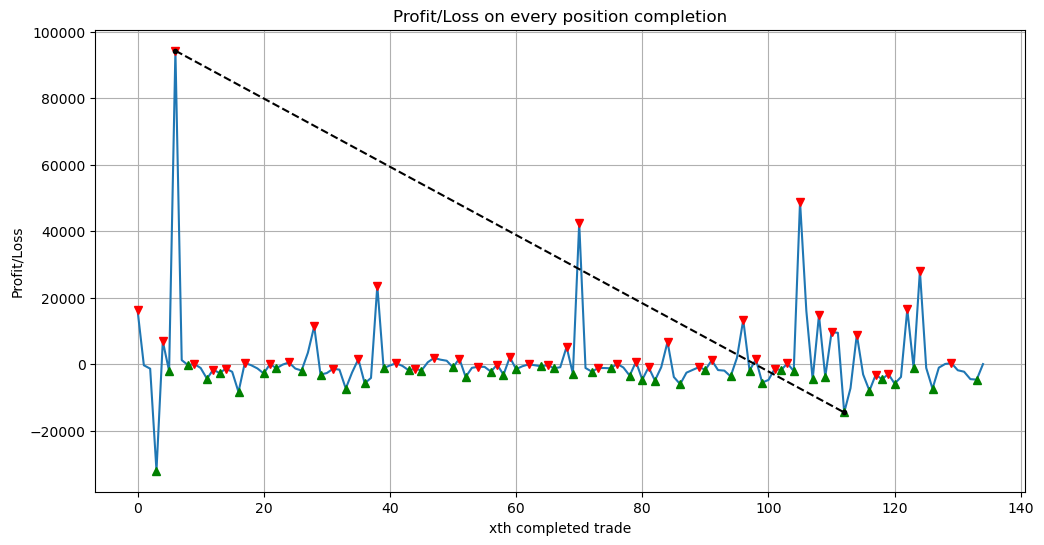

In [1213]:
plt.figure(figsize=(12,6))
plt.plot(profits)
for dd in dds:
    plt.plot(dd[1][0], dd[1][1], marker='v', color='r')
    plt.plot(dd[2][0], dd[2][1], marker='^', color='g')
plt.plot([max_dd[1][0], max_dd[2][0]], [max_dd[1][1], max_dd[2][1]], marker = '.', linestyle='--', color='black')
plt.grid(True)
plt.title("Profit/Loss on every position completion")
plt.xlabel("xth completed trade")
plt.ylabel("Profit/Loss")
plt.show()

In [1179]:
def plot_futures_and_ema(df, start_date, end_date):
    symbol = df['symbol'].iloc[0]
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    df = df.copy()
    df = df.loc[start:end]
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['close']/100, color='black')
    plt.plot(df.index, df['short']/100, color='green')
    plt.plot(df.index, df['long']/100, color='red')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.title(f'{symbol} Future Close Prices Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price (in Rs)')
    plt.tight_layout() 
    plt.show()

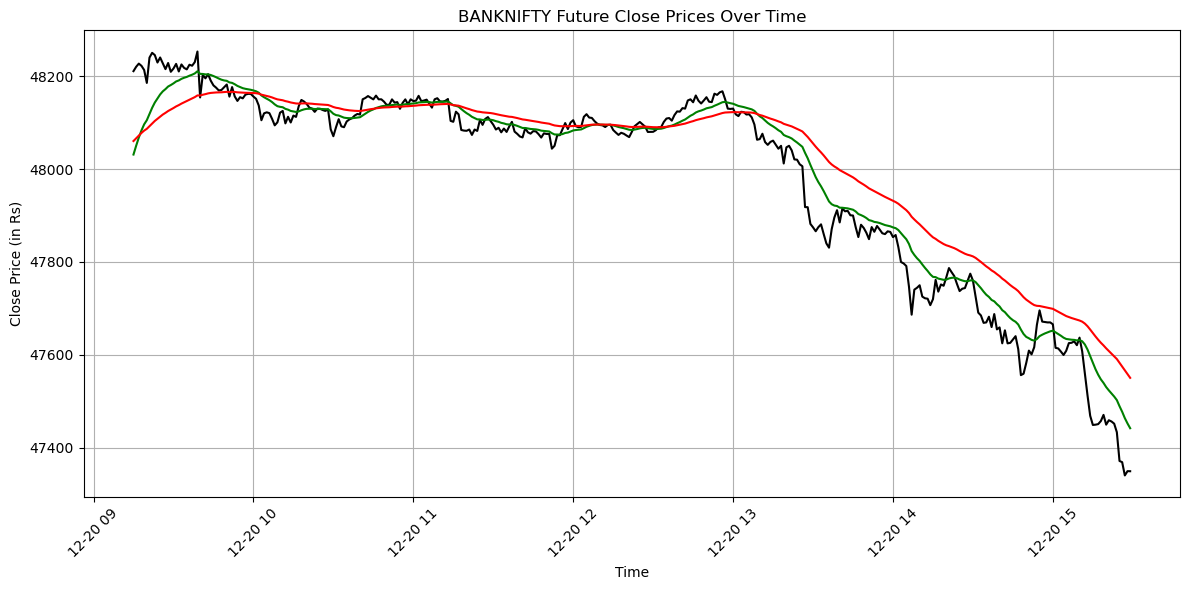

In [1181]:
plot_futures_and_ema(df_futures, '2023-12-20', '2023-12-21')

In [1183]:
def plot_options_and_trades(df_options, df_options_in_ram, opt_type, start_date, df_trades, filter_ticks):
    symbol = df_options['symbol'].iloc[0]
    
    start = pd.to_datetime(start_date)
    # end = pd.to_datetime(end_date)
    
    df_lala_options = df_options_in_ram[opt_type].copy()
    # df_lala_options = df_lala_options.loc[start:end]
    df_lala_options = df_lala_options[df_lala_options.index.date == start.date()]

    df_lala_trades = df_trades[df_trades['Call/Put'] == opt_type]
    # df_lala_trades = df_lala_trades.copy().loc[start:end]
    df_lala_trades = df_lala_trades[df_lala_trades.index.date == start.date()]

    strikes_traded = df_lala_trades['strike_price'].unique()
    num_strikes = len(strikes_traded)
    cols = 1
    rows = (num_strikes// cols) + (num_strikes % cols > 0)

    figure, axes = plt.subplots(rows, cols, figsize=(15, 5*rows), squeeze = False)
    axes = axes.flatten()
    
    for i, strike in enumerate(strikes_traded):
        ax = axes[i]
        ax.plot(df_lala_options.index, df_lala_options[strike]/100)
        trade_lines = df_lala_trades['strike_price'] == strike
        trade_lines = df_lala_trades[trade_lines]

        start_loop = int(trade_lines['Position'].iloc[0] == 0)
        for j in range(start_loop, len(trade_lines)-1, 2):
            ax.plot([trade_lines.index[j], trade_lines.index[j+1]], [trade_lines['Price'].iloc[j]/100, trade_lines['Price'].iloc[j+1]/100], color = 'green', marker="o")
            # ax.plot(trade_lines.index[j], trade_lines['Price'].iloc[j]/100, color = 'green', marker="o")
            # ax.plot(trade_lines.index[j+1], trade_lines['Price'].iloc[j+1]/100, color = 'green', marker="o")

        name = "Put"
        if opt_type:
            name = "Call"
        ax.set_title(f"{name} Options price and trades with strike = {strike}")
        ax.set_xlabel("time stamps")
        ax.set_ylabel("close prices in Rs")
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
 
        # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(FuncFormatter(filter_ticks))
   
    for j in range(len(strikes_traded), len(axes)):
        figure.delaxes(axes[j])

    plt.tight_layout() 
    plt.show()

In [1185]:
def filter_ticks(x, pos=None):
    dt = mdates.num2date(x)
    if dt.hour < 9 or (dt.hour == 15 and dt.minute > 29) or dt.hour > 15:
        return ''
    return dt.strftime('%Y-%m-%d %H:%M')

In [1187]:
def plot_all_traded_options(df_options, df_ram, start, df_trades, filter_ticks):
    plot_options_and_trades(df_options, df_ram, 1, start, df_trades, filter_ticks)
    plot_options_and_trades(df_options, df_ram, 0, start, df_trades, filter_ticks)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


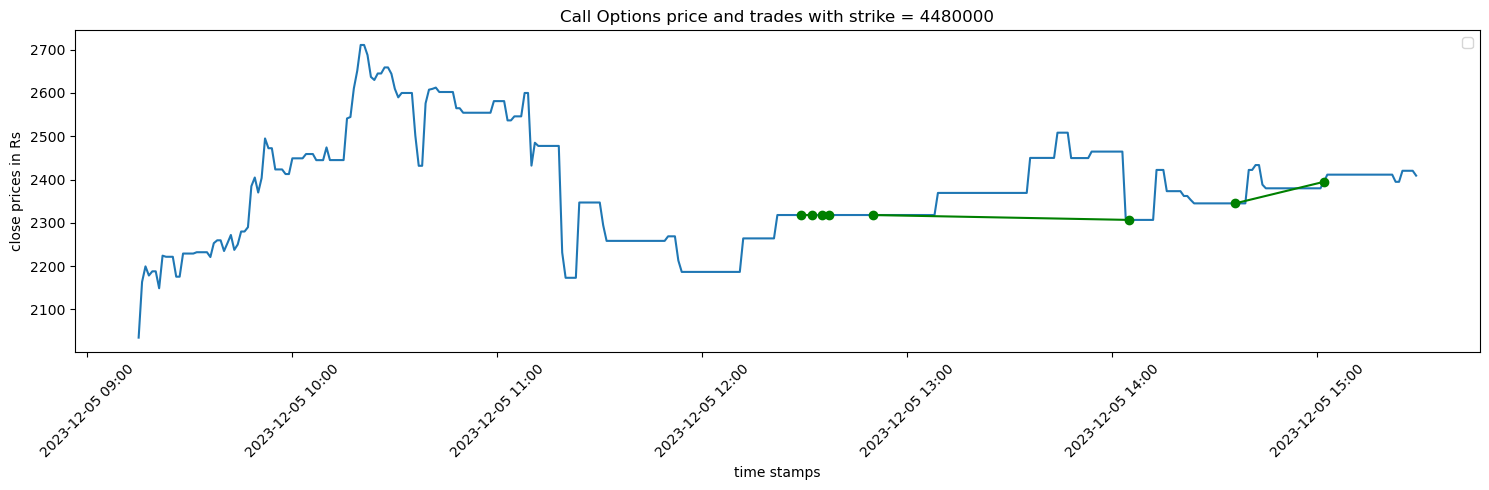

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


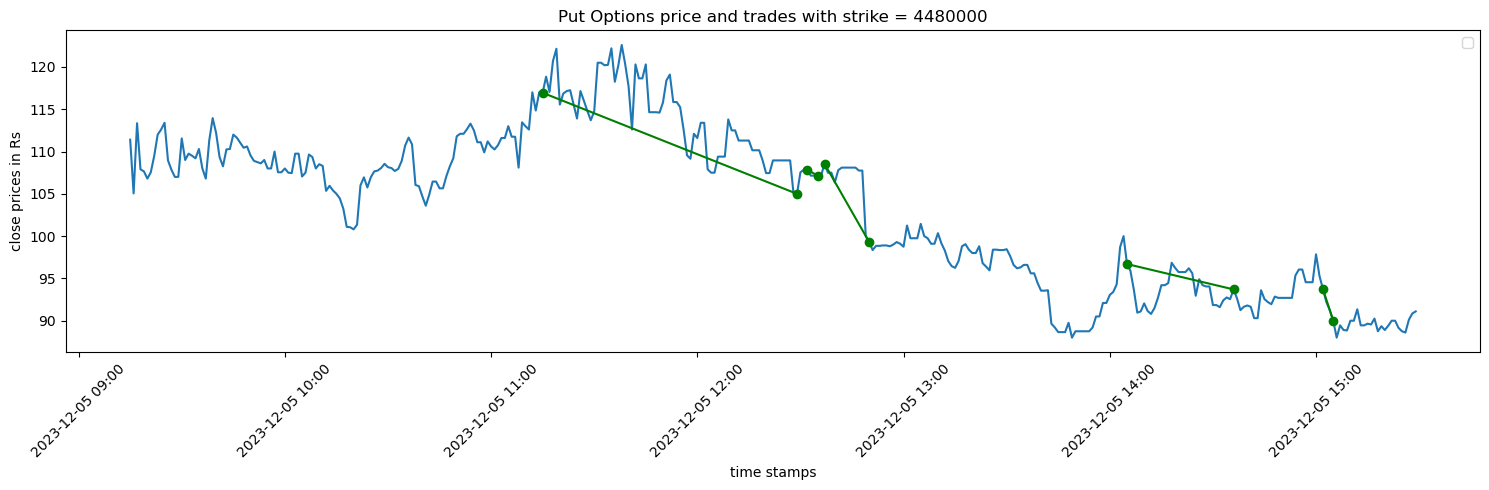

In [1189]:
plot_all_traded_options(df_options, df, '2023-12-05', df_trades, filter_ticks)

In [1215]:
class metrics:
    def __init__(self, trades, profits, fund_locked, risk_free_rate=12):
        self.fund_locked = fund_locked
        self.risk_free_rate = risk_free_rate
        self.trades = trades
        self.profits = pd.Series(profits)

    def number_of_trades(self):
        return self.trades.count().iloc[0]

    def net_profit(self):
        profits = self.profits
        return profits.sum()

    def net_turnover(self):
        prices = self.trades['Price']
        return prices.sum()
        
    def net_expenditure(self, transaction_costs = 11.5, slippage = 10):
        # 1% = 100 basis points => total_turnover * 0.01/100 * total_basis_points
        expenses = self.net_turnover() * (0.01/100) * (transaction_costs + slippage)
        return expenses

    def net_return(self):
        return 100*self.net_profit()/self.fund_locked

    def sharpe(self):
        std_profits = self.profits.std()
        std_returns = std_profits / self.fund_locked
        sharpe_ratio = self.net_return() - (self.risk_free_rate/ 12)
        sharpe_ratio /= 100
        sharpe_ratio /= std_returns
        return sharpe_ratio

    def max_drawdown(self):
        profits = self.profits
        increments = [(profits[i] - profits[i - 1]) for i in range(1, len(profits))]
        dd = 0
        max_dd = 0
        for inc in increments:
            dd += inc
            dd = min(0, dd)
            max_dd = min(dd, max_dd)
        return max_dd

In [1217]:
# metrics = metrics(df_trades_test, profits_test, 100000, 12)
metrics = metrics(df_trades, profits, 10000000, 12)

In [1219]:
number_of_trades = metrics.number_of_trades()
sharpe = metrics.sharpe()
net_profit = metrics.net_profit()
net_expenditure = metrics.net_expenditure()
net_return = metrics.net_return()
max_drawdown = metrics.max_drawdown()

print("number of trades:", number_of_trades)
print("sharpe:", sharpe)
print("net profit:", f"₹{net_profit/100}")
print("net expenditure (transaction costs + slippage):", f"₹{net_expenditure/100}")
print("net return:", f"{net_return}%")
print("max drawdown in PNL:", f"₹{abs(max_drawdown)/100}")

number of trades: 270
sharpe: 1.3825491313934932
net profit: ₹1161.15
net expenditure (transaction costs + slippage): ₹278.4674625
net return: 1.16115%
max drawdown in PNL: ₹1088.2
